In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
import scipy
import statsmodels.api as sm
import pystan
pd.options.display.precision = 2

%matplotlib inline
custom_style = {'axes.labelcolor': 'white',
                'xtick.color': 'white',
                'ytick.color': 'white'}
sns.set_style("darkgrid", rc=custom_style)
sns.set_context('notebook')
plt.style.use('dark_background')
plt.figure(figsize=(15,10))
sns.set_palette("pastel")

<Figure size 1080x720 with 0 Axes>

In [2]:
df = pd.read_csv('./data7a.csv')
N = 8
df['N-y'] = N - df['y']
df['Intercept'] = 1.0

In [3]:
df.head()

,id,y,N-y,Intercept
0,1,0,8,1.0
1,2,2,6,1.0
2,3,7,1,1.0
3,4,8,0,1.0
4,5,1,7,1.0


In [4]:
glm = sm.GLM(endog=df[['y', 'N-y']], exog=df['Intercept'], family=sm.families.Binomial())
fit = glm.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           ['y', 'N-y']   No. Observations:                  100
Model:                            GLM   Df Residuals:                       99
Model Family:                Binomial   Df Model:                            0
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -380.97
Date:                Mon, 01 Oct 2018   Deviance:                       631.49
Time:                        08:00:33   Pearson chi2:                     491.
No. Iterations:                     3   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0150      0.071      0.212      0.832      -0.124       0.154
==============================================================================
"""

In [5]:
q = 1 / (1 + np.exp(-fit.params[0]))
y = stats.binom.rvs(8, q, size=100)
print('二項分布から算出された生存確率: {:.3f}'.format(q))
print('二項分布の分散: {:.2f}'.format(N * q * (1-q)))
print('観測データの分散: {:.2f}'.format(df['y'].var()))

二項分布から算出された生存確率: 0.504
二項分布の分散: 2.00
観測データの分散: 9.93


In [6]:
y_hist = df['y'].value_counts(sort = False)

In [7]:
y_pred = np.bincount(y)
x_pred = np.linspace(0,len(np.bincount(y))-1,len(np.bincount(y))).astype(np.int)

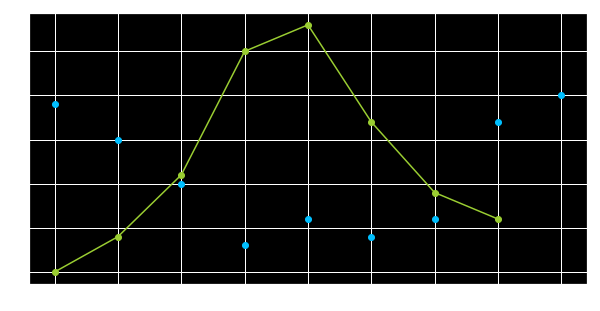

In [8]:
plt.figure(figsize=(10,5))
plt.scatter(y_hist.index, y_hist, color='deepskyblue')
plt.plot(x_pred, y_pred, marker = 'o', color='yellowgreen')

## まずは二項分布を使ってベイズで推定

In [100]:
stan_model = """
    data{
        int<lower=1> N;
        int<lower=1> C;
        int<lower=0> y[N];
    }
    
    parameters {
        real beta;
    }
    
    transformed parameters{
        real theta;
        theta = 1 / (1 + exp(beta));
    }
    
    model{
        theta ~ normal(0, 100);
        for(n in 1:N){
            y[n] ~ binomial(C, theta);
        }
    }
"""

In [101]:
sm = pystan.StanModel(model_code = stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3b803bdde6d730ab99a34ba66c31051d NOW.


In [102]:
stan_data = {"N": len(df), "C":(df['y'].unique()).max(), "y": df["y"]}
fit = sm.sampling(data=stan_data, iter=1600, warmup=100, chains=1, seed=123)

In [103]:
fit

Inference for Stan model: anon_model_3b803bdde6d730ab99a34ba66c31051d.
1 chains, each with iter=1600; warmup=100; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=1500.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta   -0.02  2.9e-3   0.07  -0.15  -0.07  -0.02   0.03   0.12    593    1.0
theta    0.5  7.2e-4   0.02   0.47   0.49    0.5   0.52   0.54    593    1.0
lp__  -554.9    0.02   0.68 -557.0 -555.1 -554.7 -554.5 -554.5    997    1.0

Samples were drawn using NUTS at Sun Sep 30 20:49:08 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [106]:
beta1 = fit.get_posterior_mean()[0][0]
theta = fit.get_posterior_mean()[1][0]

In [109]:
print('二項分布から算出された生存確率: {:.3f}'.format(q))
print('二項分布の分散: {:.2f}'.format(N * q * (1-q)))
print('stanから算出された生存確率: {:.3f}'.format(theta))
print('stabの分散: {:.2f}'.format(N * theta * (1-theta)))
print('観測データの分散: {:.2f}'.format(df['y'].var()))

二項分布から算出された生存確率: 0.504
二項分布の分散: 2.00
stanから算出された生存確率: 0.504
stabの分散: 2.00
観測データの分散: 9.93


## 階層ベイズ

In [75]:
stan_model2 = """
    data{
        int<lower=1> N;
        int<lower=1> C;
        int<lower=0> y[N];
    }
    
    parameters {
        real beta;
        real s;
        real r[N];
    }
    
    transformed parameters{
        real theta[N];
        for(n in 1:N){
            theta[n] = 1 / (1 + exp(beta + r[n] ));
        }
    }
    
    model{
        theta ~ normal(0, 100);
        s ~ normal(0, 100);
        
        for(n in 1:N){
            r[n] ~ normal(0, s);
        }
        for(n in 1:N){
            y[n] ~ binomial(C, theta[n]);
        }
    }
    
    generated quantities{
        real theta_pred[N];
        real r_pred[N];
        int<lower=0> y_pred[N];
        for(n in 1:N){
            r_pred[n] = normal_rng(0, s);
            theta_pred[n] = 1 / (1 + exp(beta + r[n] ));
            y_pred[n] = binomial_rng(C, theta_pred[n]);
        }
        
    
    } 
    
    
"""

In [76]:
sm2 = pystan.StanModel(model_code = stan_model2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_310c849e97ba5abc9095a557144f2c9a NOW.


In [77]:
stan_data2 = {"N": len(df), "C":(df['y'].unique()).max(), "y": df["y"]}
fit2 = sm2.sampling(data=stan_data2, iter=1600, warmup=100, chains=1, seed=123)

In [78]:
y_pred = fit2.extract()['y_pred'].astype(np.int)
y_pred_count = list((map(np.bincount, y_pred)))
df_pred = pd.DataFrame(y_pred_count)

In [79]:
df_pred

,0,1,2,3,4,5,6,7,8
0,18,11,8,7,6,10,5,13,22
1,19,16,7,9,6,4,10,8,21
2,16,15,11,7,7,6,6,12,20
3,25,11,3,6,2,11,10,18,14
4,22,7,7,5,9,8,11,10,21
5,24,13,6,4,6,5,8,14,20
6,20,14,8,5,6,5,13,18,11
7,24,11,7,7,6,7,5,16,17
8,21,11,6,9,7,5,6,12,23
9,20,9,11,8,6,2,9,6,29


In [81]:
y_005 = df_pred.quantile(0.05,axis=0)
y_095 = df_pred.quantile(0.95,axis=0)
y_mean = df_pred.mean(axis=0)
x_pred = df_pred.columns.values

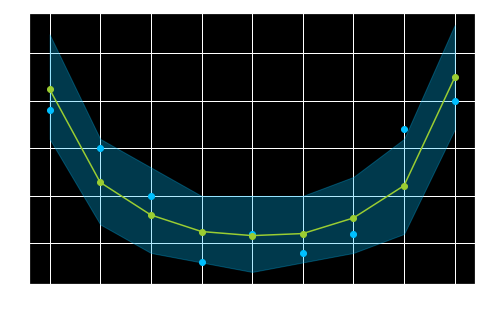

In [88]:
plt.figure(figsize=(8,5))
plt.scatter(y_hist.index, y_hist, color='deepskyblue')
plt.plot(x_pred, df_pred.mean(axis=0), marker = 'o', color='yellowgreen')
plt.fill_between(x_pred, y_005, y_095, color='deepskyblue', alpha = 0.3)